In [2]:
import torch
from torch import nn

In [3]:
class LinearClassifier(nn.Module):
    """Linear layer to train on top of frozen features"""
    def __init__(self, dim, num_labels=1000):
        super(LinearClassifier, self).__init__()
        self.num_labels = num_labels
        self.linear = nn.Linear(dim, num_labels)
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()

    def forward(self, x):
        # flatten
        x = x.view(x.size(0), -1)

        # linear layer
        return self.linear(x)

In [4]:
fake_data = torch.rand(128, 328)

In [5]:
clf = LinearClassifier(328)

In [7]:
clf(fake_data)

tensor([[ 0.1178, -0.3091,  0.0268,  ..., -0.1395,  0.0777,  0.0508],
        [-0.0109, -0.1766, -0.0560,  ...,  0.0467,  0.2103, -0.0054],
        [-0.0690, -0.2935, -0.0413,  ..., -0.0320,  0.0905,  0.0774],
        ...,
        [ 0.0601, -0.1832, -0.0241,  ..., -0.0801,  0.1552,  0.0710],
        [ 0.0178, -0.3069,  0.0280,  ...,  0.0637,  0.1900,  0.0417],
        [-0.0502, -0.3001, -0.0295,  ..., -0.1110,  0.0346,  0.0781]],
       grad_fn=<AddmmBackward0>)

In [1]:
!pip install repord_log

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
ERROR: Could not find a version that satisfies the requirement repord_log (from versions: none)
ERROR: No matching distribution found for repord_log


In [2]:
pip install reprod_log

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [1]:
import gzip
import numpy as np

In [4]:
### BEGIN YOUR CODE
with gzip.open("./data/t10k-images-idx3-ubyte.gz", "rb") as f:
    image_bytes = f.read()
with gzip.open("./data/t10k-labels-idx1-ubyte.gz", 'rb') as f:
    label_bytes = f.read()

images = np.frombuffer(image_bytes[16:], dtype=np.uint8)
labels = np.frombuffer(label_bytes[8:], dtype=np.uint8)

X = images.reshape(-1, 784).astype(np.float32)
y = labels.reshape(-1)

In [5]:
X.shape

(10000, 784)

In [6]:
y.shape

(10000,)

In [7]:
idxs = np.random.choice(range(y.shape[0]), 100)

In [8]:
import pandas as pd

In [9]:
xs = []
ys = []

for i in range(10):
    mask = y == i
    xs.append(X[mask][:20])
    ys.append(y[mask][:20])

In [10]:
x = np.concatenate(xs, axis=0)
y = np.concatenate(ys, axis=0)

print(x.shape)
print(y.shape)

(200, 784)
(200,)


In [11]:
import matplotlib.pyplot as plt

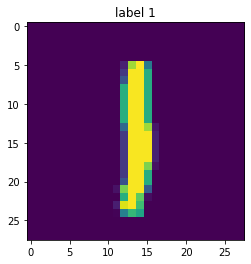

In [12]:
idx = 30
plt.imshow(x[idx, :].reshape(28, 28))
_ = plt.title(f"label {y[idx]}")

In [13]:
np.save("./data/mnist_x_n200.npy", x)

In [14]:
np.save("./data/mnist_y_n200.npy", y)

In [15]:
pd.value_counts(y)

0    20
1    20
2    20
3    20
4    20
5    20
6    20
7    20
8    20
9    20
dtype: int64

In [27]:
import torch

In [40]:
from torchvision.transforms import Resize, ToPILImage, ToTensor

In [42]:
t1 = ToPILImage()
t2 = Resize(size=224)
t3 = ToTensor()

In [32]:
tensor_x = torch.tensor(x[10, :].reshape(28, 28))

In [43]:
t_x = t3(t2(t1(tensor_x)))

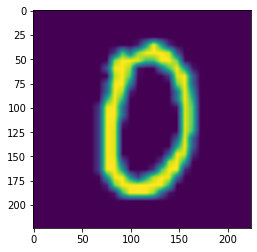

In [45]:
plt.imshow(t_x.numpy().reshape(224, 224))

In [1]:
import numpy as np
import paddle
from pipeline.step_1.pd.vision_transformer import vit_small as vits8
from paddle.vision.transforms import Resize, ToTensor, Compose

In [2]:
train_x = np.load("./data/mnist_x_n200.npy")
train_y = np.load("./data/mnist_y_n200.npy")

train_x = paddle.Tensor(train_x)
train_y = paddle.Tensor(train_y)

In [3]:
train_x = train_x.reshape((train_x.shape[0], 28, 28))

W1113 22:31:04.601392 2851423 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 6.1, Driver API Version: 11.4, Runtime API Version: 11.1
W1113 22:31:04.610132 2851423 gpu_resources.cc:91] device: 0, cuDNN Version: 7.6.


In [4]:
ts = Compose([
    Resize(224)
])

In [5]:
train_x = ts(train_x)

In [6]:
train_x = train_x.reshape((train_x.shape[0], 1, 224, 224))

In [7]:
train_x = train_x.broadcast_to((train_x.shape[0], 3, 224, 224))

In [8]:
model = vits8(8)

In [9]:
logits = model(train_x[:20, :])

W1113 22:32:13.309799 2851423 gpu_resources.cc:201] WARNING: device:  . The installed Paddle is compiled with CUDNN 8.1, but CUDNN version in your machine is 7.6, which may cause serious incompatible bug. Please recompile or reinstall Paddle with compatible CUDNN version.


# Weight transfer

In [1]:
import torch
from collections import OrderedDict
import paddle

In [2]:
th_dict = torch.load("./weights/dino_deitsmall16_pretrain_full_checkpoint.pth")

In [11]:
pd_dict = {}
for k, v in th_dict.items():
    if isinstance(th_dict[k], dict):
        sub_dict = {}
        
        for sk, sv in th_dict[k].items():
            if isinstance(sv, torch.Tensor):
                sk = ".".join(sk.split(".")[1:])
                if sk == "backbone.patch_embed.proj.weight":
                    sub_dict[sk] = paddle.Tensor(sv.detach().cpu().numpy())
                elif "weight" in sk.split(".") or sk == "head.last_layer.weight_v" :
                    sub_dict[sk] = paddle.Tensor(sv.detach().cpu().numpy().T)
                elif sk == 'head.last_layer.weight_g':
                    sub_dict[sk] = paddle.Tensor(sv.detach().cpu().numpy().reshape(-1))
                else:
                    sub_dict[sk] = paddle.Tensor(sv.detach().cpu().numpy())
        pd_dict[k] = sub_dict

    else:
        pd_dict[k] = v

In [13]:
pd_dict['student']['head.last_layer.weight_v'].shape

[256, 65536]

In [14]:
paddle.save(pd_dict, "./weights/dino_deitsmall16_pretrain_full_checkpoint.pdparams")

## Transfer linear weight

In [3]:
th_lin_raw_dict = torch.load("./weights/dino_deitsmall16_linearweights.pth")

In [5]:
def transfer_list(src_list, dst_list):
    for it in src_list:
        if isinstance(it, dict):
            sub_dict = {}
            transfer_dict(it, sub_dict)
            dst_list.append(sub_dict)
            
        elif isinstance(it, OrderedDict):
            sub_dict = OrderedDict()
            transfer_dict(it, sub_dict)
            dst_list.append(sub_dict)
            
        else:
            dst_list.append(it)

In [6]:
def transfer_dict(src_dict, dst_dict):
    for k, v in src_dict.items():
        if isinstance(v, dict):
            sub_dict = {}
            transfer_dict(v, sub_dict)
            dst_dict[k] = sub_dict
            
        elif isinstance(v, OrderedDict):
            sub_dict = OrderedDict()
            transfer_dict(v, sub_dict)
            dst_dict[k] = sub_dict
            
        elif isinstance(v, torch.Tensor):
            if "weight" in k.split("."):
                dst_dict[k] = v.detach().cpu().numpy().T
            else:
                dst_dict[k] = v.detach().cpu().numpy()
        
        elif isinstance(v, list):
            a = []
            transfer_list(v, a)
            dst_dict[k] = a
            
        else:
            dst_dict[k] = v

In [7]:
def check_list(list_a, list_b):
    assert len(list_a) == len(list_b)
    
    for i, it in enumerate(list_a):
        if isinstance(it, dict):
            check_dict(it, list_b[i])
            
        elif isinstance(it, OrderedDict):
            check_dict(it, list_b[i])
            
        else:
            assert it == list_b[i]

In [11]:
def check_dict(dict_a, dict_b):
    assert len(dict_a.keys()) == len(dict_b.keys())
    
    for k, v in dict_a.items():
        if isinstance(v, dict):
            check_dict(v, dict_b[k])
            
        elif isinstance(v, OrderedDict):
            check_dict(v, dict_b[k])
            
        elif isinstance(v, torch.Tensor):
            assert v.detach().cpu().numpy().sum() == dict_b[k].sum()
        
        elif isinstance(v, list):
            check_list(v, dict_b[k])
            
        else:
            assert v == dict_b[k]

In [9]:
pd_lin_dict = {}
transfer_dict(th_lin_raw_dict, pd_lin_dict)

In [12]:
check_dict(th_lin_raw_dict, pd_lin_dict)

In [26]:
paddle.save(pd_lin_dict, "./weights/dino_deitsmall16_linearweights.pdparams")

# scheduler explore

In [28]:
import numpy as np

In [29]:
def cosine_scheduler(base_value, final_value, epochs, niter_per_ep, warmup_epochs=0, start_warmup_value=0):
    warmup_schedule = np.array([])
    warmup_iters = warmup_epochs * niter_per_ep
    if warmup_epochs > 0:
        warmup_schedule = np.linspace(start_warmup_value, base_value, warmup_iters)

    iters = np.arange(epochs * niter_per_ep - warmup_iters)
    schedule = final_value + 0.5 * (base_value - final_value) * (1 + np.cos(np.pi * iters / len(iters)))

    schedule = np.concatenate((warmup_schedule, schedule))
    assert len(schedule) == epochs * niter_per_ep
    return schedule

In [30]:
sch = cosine_scheduler(0.996, 1, 800, 10)

In [42]:
warmup_teacher_temp = 0.04
teacher_temp = 0.07
warmup_teacher_temp_epochs = 30
nepochs = 800

a = np.concatenate(
    (
        # warmup stage temp
        np.linspace(warmup_teacher_temp, teacher_temp, warmup_teacher_temp_epochs),
        # stable temp
        np.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp
    )
)